In [65]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold, cross_validate
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, QuantileTransformer, MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xgboost as xgb
import lightgbm as lgbm
import pygam as gam

from datetime import datetime

import re, itertools, functools, os

In [2]:
# load training dataset
train_df = pd.read_csv('train.csv')
# load submission dataset
submission_df = pd.read_csv('test.csv')

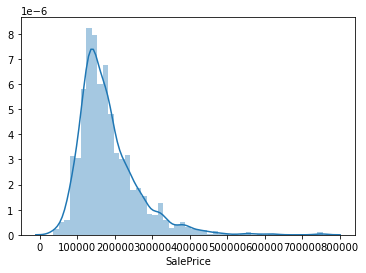

In [3]:
# check distribution of target variable
sns.distplot(train_df['SalePrice'])
plt.show()

In [4]:
# there is a right skew, what's the value?
stats.skew(train_df['SalePrice'])

1.880940746034036

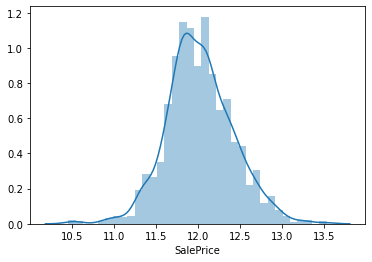

0.12122191311528363

In [5]:
# what if we apply a log transformation?
sns.distplot(np.log1p(train_df['SalePrice']))
plt.show()
stats.skew(np.log1p(train_df['SalePrice']))

In [6]:
# we will apply the log transformation when making models

# let's remove variables with high null values
null_rate = train_df.isna().sum() / train_df.shape[0]
null_rate.sort_values(ascending=False, inplace=True)
null_rate.iloc[:10]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64

In [7]:
# remove above 30%
drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
train_df.drop(drop, axis=1, inplace=True)
submission_df.drop(drop, axis=1, inplace=True)

In [8]:
# there are some obvious features that can be created from the data
def feature_engineering(x):
    # difference between built and sold
    x['HouseAge'] = x['YrSold'].fillna(0) - x['YearBuilt'].fillna(0)
    # finished area of basement
    x['BsmtFinishedSF'] = x['TotalBsmtSF'].fillna(0) - x['BsmtUnfSF'].fillna(0)
    # total finished area
    x['GrFinishedSF'] = x['GrLivArea'].fillna(0) - x['LowQualFinSF'].fillna(0)
    # total full baths
    x['TotalFullBaths'] = x['BsmtFullBath'].fillna(0) + x['FullBath'].fillna(0)
    # total half batchs
    x['TotalHalfBaths'] = x['BsmtHalfBath'].fillna(0) + x['HalfBath'].fillna(0)
    # total porch+deck area
    x['TotalPorchDeckArea'] = x[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].fillna(0).sum(axis=1)
    return x

In [9]:
# add features created
train_df = feature_engineering(train_df)
submission_df = feature_engineering(submission_df)

In [10]:
# some functions to plot distributions/scatter plots
def plot_numeric_distribution(data, variable: str, bins=50):
    """
    Plot distribution of variable.
    """
    # set up two subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax = ax.flatten()
    # one a simple distribution plot
    sns.distplot(data[variable], bins=bins, ax=ax[0])
    ax[0].set_title('Distribution')
    # do a cumulative dist
    sns.distplot(data[variable], bins=bins, hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
    ax[1].set_title('Cumulative Distribution')
    # title
    fig.suptitle(variable, fontsize=14)
    plt.show()


def bootstrap(x, fraction: float=0.3, times: int=300, alpha=0.05):
    """
    Samples x multiple times and returns mean, and upper and lower bounds of alpha.
    """
    arr = np.zeros(times)
    size = x.shape[0]
    sample_size = int(size * fraction)
    for i in range(times):
        # sample
        s = np.random.choice(x, size=sample_size, replace=False).mean()
        # calculate mean
        arr[i] = s
    # return actual mean, calculated mean, and upper/lower bounds
    lower, median, upper = np.quantile(arr, [alpha / 2, 0.5, 1 - alpha / 2])
    return pd.Series({
        'actual mean': x.mean(), 'bootstrap mean': arr.mean(), 
        'bootstrap median': median, 'lower bound': lower, 'upper bound': upper})


def plot_categorical_distribution(data, variable: str, max_display: int=20, return_data=False):
    """
    Plot distribution of categorical variable - along with confidence bounds.
    """
    # for each value, including NaN, create column
    save = pd.DataFrame()
    for value in data[variable].unique():
        if value is np.nan:
            save['_nan'] = data[variable].isna().astype(int)
        else:
            save[value] = (data[variable] == value).astype(int)
    # for each column, apply bootstrap
    result = save.apply(bootstrap, axis=0).T
    
    # if result size is greater than max_display, cap it
    copy = None
    if result.shape[0] > max_display:
        print('Reducing Size.')
        copy = result.copy(deep=True)
        result.sort_values('bootstrap mean', ascending=False, inplace=True)
        result = result.iloc[:max_display]
    
    # create plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    # plot bootstrap mean
    ax.bar(result.index, result['bootstrap mean'])
    lower_bound = result['bootstrap mean'] - result['lower bound']
    upper_bound = - result['bootstrap mean'] + result['upper bound']
    ax.errorbar(result.index, result['bootstrap mean'], yerr=[lower_bound, upper_bound], linestyle='', color='black')
    ax.set_title(variable, fontsize=15)
    plt.show()
    if return_data:
        if copy is not None:
            return copy
        else:
            return result
    else:
        return None
    
def plot_scatter(data: pd.DataFrame, x: str, y: str, categorical: bool) -> None:
    """
    Produces a scatter plot for x vs y - y should be numeric!
    """
    plt.figure(figsize=(15, 7))
    if not categorical:
        plt.scatter(data[x], data[y])
        plt.title('{} vs {} Scatterplot'.format(x, y))
        plt.show()
    elif categorical:
        sns.boxplot(y=data[y], x=data[x].fillna('_nan'))
        plt.title('{} vs {} Scatterplot'.format(x, y))
        plt.show()
    else:
        raise Exception('Invalid categorical bool')

In [11]:
# a summarizing to plot both, distribution and scatter
def plot_dist_and_scatter(data, x, y, categorical):
    if categorical:
        plot_categorical_distribution(data, x)
        plot_scatter(data, x, y, categorical=True)
    else:
        plot_numeric_distribution(data, x)
        plot_scatter(data, x, y, categorical=False)

In [12]:
limits = {
    'BsmtFinSF1': [0, 3000],
    'BsmtFinSF2': [0, 1200],
    'TotalBsmtSF': [0, 4000],
    '1stFlrSF': [0, 4000],
    'GrLivArea': [0, 4000],
    'BsmtFullBath': [0, 2],
    'BsmtHalfBath': [0, 1],
    'BedroomAbvGr': [0, 6],
    'KitchenAbvGr': [1, 2],
    'TotRmsAbvGrd': [3, 12],
    'GarageArea': [0, 1300],
    'WoodDeckSF': [0, 800],
    'OpenPorchSF': [0, 500],
    'EnclosedPorch': [0, 500],
    '3SsnPorch': [0, 500],
    'ScreenPorch': [0, 450],
    'BsmtFinishedSF': [0, 3000],
    'GrFinishedSF': [0, 4000],
    'TotalFullBaths': [1, 6],
    'TotalHalfBaths': [0, 2],
    'TotalPorchDeckArea': [0, 900]
}

In [13]:
# let's apply the various limits
def outliers(rules, data):
    rules_list = []
    for k, v in rules.items():
        cond = (data[k] >= v[0]) & (data[k] <= v[1])
        rules_list.append(cond)
    return rules_list

outlier_ids = train_df.loc[~pd.concat(outliers(limits, train_df), axis=1).apply(np.all, axis=1), 'Id']

In [14]:
# now we want to encode categoricals as binary, ordinal, or one hot encode if necessary, and lastly numeric
feature_encoding = {
    'ordinal': {'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 'BsmtCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                'BsmtExposure': ['No', 'Mn', 'Av', 'Gd'], 'BsmtFinType1': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                'BsmtFinType2': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], 'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 'GarageFinish': ['Unf', 'RFn', 'Fin'],
                'GarageQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 'GarageCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex']},
    'onehot': ['MSSubClass', 'MSZoning', 'Street', 
               'LandContour', 'LotShape', 'LotConfig', 
               'LandSlope', 'Neighborhood', 'Condition1',
               'BldgType', 'HouseStyle', 'OverallCond',
               'RoofStyle', 'Exterior1st', 'Exterior2nd',
               'MasVnrType', 'Foundation', 'BsmtExposure',
               'GarageType', 'PavedDrive', 'MoSold',
               'SaleType', 'SaleCondition'],
    'binary': {'OverallCond': 5, 'CentralAir': 'Y', 'Electrical': 'SBrkr'},
    'numeric': ['LotFrontage', 'LotArea', 'OverallQual', 
                'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                'FullBath', 'HalfBath', 'BedroomAbvGr',
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                'GarageCars', 'GarageArea', 'WoodDeckSF',
                'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                'ScreenPorch', 'HouseAge', 'BsmtFinishedSF',
                'GrFinishedSF', 'TotalFullBaths', 'TotalHalfBaths'],
    'remove': ['Utilities', 'Condition2', 'RoofMatl',
               'Heating', 'LowQualFinSF', 'Functional',
               'GarageYrBlt', 'PoolArea', 'MiscVal',
               'YrSold']
}

In [15]:
# remove columns
train_df.drop(feature_encoding['remove'], axis=1, inplace=True)
submission_df.drop(feature_encoding['remove'], axis=1, inplace=True)

In [16]:
# apply ordinal encodings
def apply_ordinal_encoding(encodings, data):
    # since we don't want to modify the original dataset, return a new one
    save = pd.DataFrame(index=data.index)
    for k, v in encodings.items():
        # prepare a mapping for each
        mapping = {category: integer + 1 for integer, category in enumerate(v)}
        # mapping will be a dict like {cat1: 1, cat2: 2...}
        
        # now apply that mapping to data
        save[k] = data[k].map(mapping).fillna(0)
        
    return save

# create a new dataframe for modeling
X_train = apply_ordinal_encoding(feature_encoding['ordinal'], train_df)
X_submission = apply_ordinal_encoding(feature_encoding['ordinal'], submission_df)

In [17]:
# apply binary encoding
def apply_binary_encoding(encodings, data):
    # instead of modifying the original, return a new dataframe
    save = pd.DataFrame(index=data.index)
    for k, v in encodings.items():
        # if string
        if isinstance(v, str):
            save[k + '__{}'.format(v)] = (data[k] == v).astype(int)
        # else it's a number
        else:
            save[k + '__gte_{}'.format(v)] = (data[k] >= v).astype(int)
            
    return save

# get the encoding and add to data
X_train = pd.concat([X_train, apply_binary_encoding(feature_encoding['binary'], train_df)], axis=1)
X_submission = pd.concat([X_submission, apply_binary_encoding(feature_encoding['binary'], submission_df)], axis=1)

In [18]:
# apply one hot encoding
class MyOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, threshold=0.05):
        """
        Parameters
        ----------
        columns: list
            List of columns to apply one-hot encoding on
        threshold: float
            Minimum proportion required for a category to appear
        """
        self.columns = columns
        self.threshold = threshold
        self.categories = {}
    
    def fit(self, X, y=None):
        # make sure X has all columns
        if not np.all(list(map(lambda x: x in X.columns, self.columns))):
            raise Exception("""Error while fitting. Passed data does not have all columns to be transformed.""")
        
        # get size
        size = X.shape[0]
        
        # loop through columns
        for c in self.columns:
            # get value counts
            vc = X[c].value_counts() / size
            # for all values that are above threshold add to categories
            eligible = vc[vc >= self.threshold].index.tolist()
            # add
            if len(eligible) > 0:
                self.categories[c] = eligible
        return self
    
    def transform(self, X, y=None):
        # make sure X has all columns that actually will be transformed
        if not np.all(list(map(lambda x: x in X.columns, self.categories.keys()))):
            raise Exception("""Error while transforming. Passed data does not have all columns to be transformed.""")
        
        # list to save all transformations
        save = []
        
        # loop
        for k, v in self.categories.items():
            # get binary 1, 0 for each category
            categories = pd.concat(list(map(lambda x: (X[k] == x).astype(int), v)), axis=1)
            # change column names to add prefix
            categories.columns = [k + '__{}'.format(x) for x in v]
            # add to save
            save.append(categories)
        
        # return
        return pd.concat(save, axis=1)

In [19]:
# fit on training data
myOneHotEncoder = MyOneHotEncoder(columns=feature_encoding['onehot']).fit(train_df)

# get the transformation and append
X_train = pd.concat([X_train, myOneHotEncoder.transform(train_df)], axis=1)
X_submission = pd.concat([X_submission, myOneHotEncoder.transform(submission_df)], axis=1)

In [20]:
# lastly add numeric columns
X_train = pd.concat([X_train, train_df[feature_encoding['numeric']]], axis=1)
X_submission = pd.concat([X_submission, submission_df[feature_encoding['numeric']]], axis=1)

In [21]:
# impute using medians - which would adjust for outliers
impute = SimpleImputer(strategy='median').fit(X_train)

# transform
X_train = pd.DataFrame(impute.transform(X_train), index=X_train.index, columns=X_train.columns)
X_submission = pd.DataFrame(impute.transform(X_submission), index=X_submission.index, columns=X_submission.columns)

In [22]:
# overall scaling
scaling = PowerTransformer().fit(X_train)

# apply
X_train_scaled = pd.DataFrame(scaling.transform(X_train), index=X_train.index, columns=X_train.columns)
X_submission_scaled = pd.DataFrame(scaling.transform(X_submission), index=X_submission.index, columns=X_submission.columns)

d:\software-installs\anaconda3\envs\tensorflow-gpu-2\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [41]:
# let's do some additional transformations and test those

# PCA
pca = PCA(n_components=0.99).fit(X_train_scaled)

# apply
X_train_transformed = pd.DataFrame(pca.transform(X_train_scaled), index=X_train.index)
X_submission_transformed = pd.DataFrame(pca.transform(X_submission_scaled), index=X_submission.index)

# components?
X_train_transformed.shape, X_train_scaled.shape

((1460, 92), (1460, 121))

In [60]:
# KMeans
kmeans = KMeans(random_state=11, n_clusters=4, tol=1e-7).fit(X_train_scaled)
scaler = PowerTransformer().fit(kmeans.predict(X_train_scaled).reshape(-1, 1))

# apply
X_train_transformed = X_train_scaled.copy(deep=True)
X_train_transformed['kmeans'] = scaler.transform(kmeans.predict(X_train_scaled).reshape(-1, 1))

In [121]:
# prepare scorer, RMSLE - note that np.expm1 is applied since y will be log transformed
def rmsle(y, y_pred):
    return -np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(y_pred)))
rmsle = make_scorer(rmsle, greater_is_better=False, needs_proba=False, needs_threshold=False)

In [24]:
# function to quickly evaluate models
def quick_validation(
    estimator,
    X,
    y=np.log1p(train_df.loc[~X_train.index.isin(outlier_ids.index), 'SalePrice']),
    scoring=rmsle,
):
    splitter = ShuffleSplit(n_splits=30, test_size=0.2, random_state=11).split(X)
    cv_result = cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        scoring=scoring,
        n_jobs=12,
        cv=splitter,
        return_train_score=True,
        error_score=-1
    )
    # print means and decay
    print('Train: {:.6f}, Test: {:.6f}, Decay: {:.1%}'.format(
        np.mean(cv_result['train_score']),
        np.mean(cv_result['test_score']),
        np.mean(cv_result['test_score']) / np.mean(cv_result['train_score']) - 1
    ))
    
    return np.mean(cv_result['train_score']), np.mean(cv_result['test_score'])

In [103]:
# lasso model
lasso = Lasso(
    alpha=0.001,
    tol=1e-6,
    random_state=11,
    max_iter=2000,
    selection='cyclic'
)

quick_validation(lasso, X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)])

Train: 0.104480, Test: 0.117491, Decay: 12.5%


(0.10447958522147462, 0.1174908652704567)

In [104]:
# linear model
lm = LinearRegression(n_jobs=12)

quick_validation(lm, X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)])

Train: 0.102610, Test: 0.120935, Decay: 17.9%


(0.10260988522380989, 0.12093503255720948)

In [105]:
# ridge
ridge = Ridge(tol=1e-7, alpha=5.0, max_iter=1000)

quick_validation(ridge, X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)])

Train: 0.102700, Test: 0.119290, Decay: 16.2%


(0.10270034227707295, 0.11928986427780698)

In [99]:
# elasticnet
elasticnet = ElasticNet(
    alpha=.05,
    l1_ratio=0.001,
    max_iter=2000,
    tol=1e-6,
    positive=True,
    selection='cyclic',
    random_state=11
)

quick_validation(elasticnet, X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)])

Train: 0.110462, Test: 0.120605, Decay: 9.2%


(0.11046152864077179, 0.12060508847699182)

In [29]:
# gradient boosting
gbm = GradientBoostingRegressor(
    loss='huber',
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.9,
    min_samples_split=0.1,
    min_samples_leaf=0.05,
    max_depth=3,
    random_state=11,
    alpha=0.9,
)

quick_validation(gbm, X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)])

Train: 0.102822, Test: 0.127196, Decay: 23.7%


(0.10282246527906182, 0.1271962243182699)

In [30]:
# extreme gbm
xgbm = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.5,
    verbosity=2,
    objective='reg:squaredlogerror',
    booster='gblinear',
#     tree_method='',
    n_jobs=12,
    gamma=0.0001,
#     min_child_weight=100,
#     max_delta_step=50.0,
    subsample=0.8,
    colsample_bytree=1.0,
    colsample_bylevel=0.9,
    colsample_bynode=0.9,
    reg_alpha=0.00001,
    reg_lambda=0.001,
    random_state=11,
    importance='total_gain',
)
quick_validation(xgbm, X_train.loc[~X_train.index.isin(outlier_ids.index)])

Train: 0.120673, Test: 0.128444, Decay: 6.4%


(0.12067325111848852, 0.12844389360834602)

In [126]:
# let's perform hyper-parameter tuning on all models above

# prepare scorer, RMSLE - note that np.expm1 is applied since y will be log transformed
def rmsle_tuning(y, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(y_pred)))
rmsle_tuning = make_scorer(rmsle_tuning, greater_is_better=False, needs_proba=False, needs_threshold=False)

In [143]:
params = dict(
    alpha=[0.0005, 0.001, 0.01, 0.1, 0.2],
    tol=[1e-7],
    random_state=[11],
    selection=['cyclic'],
    max_iter=[2000]
)

lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=params,
    scoring=rmsle_tuning,
    n_jobs=12,
    cv=ShuffleSplit(30, test_size=0.2, random_state=11).split(X_train.loc[~X_train.index.isin(outlier_ids.index)]),
    verbose=10,
    error_score=np.nan,
    return_train_score=True
)

lasso.fit(
    X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)],
    np.log1p(train_df.loc[~X_train.index.isin(outlier_ids.index), 'SalePrice'])
)
print(pd.DataFrame({'rank': lasso.cv_results_['rank_test_score'], 'test': lasso.cv_results_['mean_test_score'], 'train': lasso.cv_results_['mean_train_score'],
                    'decay': lasso.cv_results_['mean_test_score'] / lasso.cv_results_['mean_train_score'] - 1}))
lasso.best_estimator_

Fitting 30 folds for each of 5 candidates, totalling 150 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1977s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 143 out of 150 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    2.1s finished


   rank      test     train     decay
0     2 -0.117904 -0.103472  0.139483
1     1 -0.117491 -0.104480  0.124534
2     3 -0.125912 -0.117308  0.073351
3     4 -0.211648 -0.204568  0.034607
4     5 -0.305630 -0.298276  0.024657


Lasso(alpha=0.001, max_iter=2000, random_state=11, tol=1e-07)

In [146]:
params = dict(
    alpha=[0.0005, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    tol=[1e-7],
    random_state=[11],
    max_iter=[2000]
)

ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid=params,
    scoring=rmsle_tuning,
    n_jobs=12,
    cv=ShuffleSplit(30, test_size=0.2, random_state=11).split(X_train.loc[~X_train.index.isin(outlier_ids.index)]),
    verbose=10,
    error_score=np.nan,
    return_train_score=True
)

ridge.fit(
    X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)],
    np.log1p(train_df.loc[~X_train.index.isin(outlier_ids.index), 'SalePrice'])
)
print(pd.DataFrame({'rank': ridge.cv_results_['rank_test_score'], 'test': ridge.cv_results_['mean_test_score'], 'train': ridge.cv_results_['mean_train_score'],
                    'decay': ridge.cv_results_['mean_test_score'] / ridge.cv_results_['mean_train_score'] - 1}))
ridge.best_estimator_

Fitting 30 folds for each of 9 candidates, totalling 270 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0350s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1450s.) Setting batch_size=4.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1280s.) Setting batch_size=8.
[Parallel(n_jobs=12)]: Done 124 tasks      | elapsed:    0.3s


   rank      test     train     decay
0     9 -0.120936 -0.102609  0.178611
1     8 -0.120936 -0.102609  0.178608
2     7 -0.120930 -0.102609  0.178550
3     6 -0.120872 -0.102609  0.177982
4     5 -0.120809 -0.102609  0.177375
5     4 -0.120750 -0.102610  0.176790
6     3 -0.120693 -0.102610  0.176227
7     2 -0.120638 -0.102611  0.175683
8     1 -0.120585 -0.102612  0.175158


[Parallel(n_jobs=12)]: Done 270 out of 270 | elapsed:    0.5s finished


Ridge(alpha=0.6, max_iter=2000, random_state=11, tol=1e-07)

In [148]:
params = dict(
    alpha=[0.0005, 0.001, 0.01, 0.1, 0.2, 0.3],
    l1_ratio=[0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9],
    tol=[1e-7],
    random_state=[11],
    max_iter=[2000],
    selection=['cyclic']
)

elasticnet = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=params,
    scoring=rmsle_tuning,
    n_jobs=12,
    cv=ShuffleSplit(30, test_size=0.2, random_state=11).split(X_train.loc[~X_train.index.isin(outlier_ids.index)]),
    verbose=10,
    error_score=np.nan,
    return_train_score=True
)

elasticnet.fit(
    X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)],
    np.log1p(train_df.loc[~X_train.index.isin(outlier_ids.index), 'SalePrice'])
)
print(pd.DataFrame({
    'rank': elasticnet.cv_results_['rank_test_score'], 
    'test': elasticnet.cv_results_['mean_test_score'], 
    'train': elasticnet.cv_results_['mean_train_score'],
    'decay': elasticnet.cv_results_['mean_test_score'] / elasticnet.cv_results_['mean_train_score'] - 1})).sort_values('rank').iloc[:20]
elasticnet.best_estimator_

Fitting 30 folds for each of 48 candidates, totalling 1440 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    5.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

    rank      test     train     decay
0     24 -0.120567 -0.102612  0.174979
1     23 -0.120536 -0.102613  0.174667
2     22 -0.120303 -0.102624  0.172280
3     19 -0.120038 -0.102645  0.169448
4     15 -0.119396 -0.102744  0.162075
5     13 -0.118657 -0.102957  0.152482
6      7 -0.118197 -0.103206  0.145249
7      6 -0.118013 -0.103363  0.141738
8     21 -0.120271 -0.102621  0.171993
9     20 -0.120216 -0.102623  0.171426
10    17 -0.119815 -0.102658  0.167134
11    16 -0.119403 -0.102722  0.162382
12    12 -0.118546 -0.102975  0.151210
13     5 -0.117852 -0.103488  0.138791
14     4 -0.117543 -0.104037  0.129826
15     2 -0.117495 -0.104315  0.126351
16    10 -0.118369 -0.102940  0.149889
17     8 -0.118204 -0.103013  0.147469
18     3 -0.117509 -0.103766  0.132438
19     1 -0.117393 -0.104675  0.121503
20    14 -0.118760 -0.107293  0.106877
21    26 -0.121028 -0.111245  0.087935
22    30 -0.123365 -0.114273  0.079560
23    31 -0.124918 -0.116121  0.075762
24     9 -0.118283 -0.106

ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=2000, random_state=11, tol=1e-07)

In [151]:
params = dict(
    loss=['ls', 'lad', 'huber', 'quantile'],
    learning_rate=[0.1, 0.5],
    n_estimators=[200],
    subsample=[0.5, 0.75, 0.9],
    min_samples_split=[0.1, 0.05],
    min_samples_leaf=[0.01, 0.02, 0.03],
    max_depth=[3, 4],
    random_state=[11],
    max_features=['sqrt', 'log2'],
    alpha=[0.1, 0.9, 0.99],
    max_leaf_nodes=[None, 10, 20],
    validation_fraction=[0.1],
    n_iter_no_change=[25],
    tol=[1e-3],
    ccp_alpha=[0.0, 0.2]
)

gbm = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=params,
    scoring=rmsle_tuning,
    n_jobs=12,
    cv=ShuffleSplit(10, test_size=0.2, random_state=11).split(X_train.loc[~X_train.index.isin(outlier_ids.index)]),
    verbose=10,
    error_score=np.nan,
    return_train_score=True
)

gbm.fit(
    X_train_scaled.loc[~X_train.index.isin(outlier_ids.index)],
    np.log1p(train_df.loc[~X_train.index.isin(outlier_ids.index), 'SalePrice'])
)
print(pd.DataFrame({
    'rank': gbm.cv_results_['rank_test_score'], 
    'test': gbm.cv_results_['mean_test_score'], 
    'train': gbm.cv_results_['mean_train_score'],
    'decay': gbm.cv_results_['mean_test_score'] / gbm.cv_results_['mean_train_score'] - 1}).sort_values('rank').iloc[:20])
gbm.best_estimator_

Fitting 10 folds for each of 10368 candidates, totalling 103680 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

[Parallel(n_jobs=12)]: Done 9736 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 10010 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 10284 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 10562 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 10840 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 11404 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 11690 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 11976 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 12266 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 12556 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 12850 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 13144 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 13442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 13740 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 14042 tasks  

[Parallel(n_jobs=12)]: Done 61466 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 61996 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 62530 tasks      | elapsed: 14.1min
[Parallel(n_jobs=12)]: Done 63064 tasks      | elapsed: 14.1min
[Parallel(n_jobs=12)]: Done 63602 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 64140 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 64682 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 65224 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 65770 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 66316 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 66866 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 67416 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 67970 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 68524 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 69082 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 69640 tasks 

        rank      test     train     decay
0        265 -0.129954 -0.109072  0.191446
1         49 -0.128003 -0.103480  0.236985
2         34 -0.127742 -0.102145  0.250588
3        153 -0.128812 -0.105621  0.219574
4         74 -0.128179 -0.101190  0.266716
...      ...       ...       ...       ...
10363  10225 -1.051762 -1.062995 -0.010567
10364  10153 -1.043500 -1.054650 -0.010572
10365  10009 -1.041056 -1.052126 -0.010522
10366  10225 -1.051762 -1.062995 -0.010567
10367  10153 -1.043500 -1.054650 -0.010572

[10368 rows x 4 columns]


AttributeError: 'NoneType' object has no attribute 'sort_values'

In [152]:
print(pd.DataFrame({
    'rank': gbm.cv_results_['rank_test_score'], 
    'test': gbm.cv_results_['mean_test_score'], 
    'train': gbm.cv_results_['mean_train_score'],
    'decay': gbm.cv_results_['mean_test_score'] / gbm.cv_results_['mean_train_score'] - 1}).sort_values('rank').iloc[:20])
gbm.best_estimator_

      rank      test     train     decay
7042     1 -0.126708 -0.095720  0.323737
130      1 -0.126708 -0.095720  0.323737
3586     1 -0.126708 -0.095720  0.323737
129      4 -0.127028 -0.101673  0.249374
3585     4 -0.127028 -0.101673  0.249374
7041     4 -0.127028 -0.101673  0.249374
7061     7 -0.127081 -0.092996  0.366518
149      7 -0.127081 -0.092996  0.366518
3605     7 -0.127081 -0.092996  0.366518
3611    10 -0.127107 -0.096045  0.323412
155     10 -0.127107 -0.096045  0.323412
7067    10 -0.127107 -0.096045  0.323412
3583    13 -0.127126 -0.098649  0.288668
127     13 -0.127126 -0.098649  0.288668
7039    13 -0.127126 -0.098649  0.288668
7047    16 -0.127186 -0.105270  0.208191
3591    16 -0.127186 -0.105270  0.208191
135     16 -0.127186 -0.105270  0.208191
7060    19 -0.127209 -0.095185  0.336441
3604    19 -0.127209 -0.095185  0.336441


GradientBoostingRegressor(alpha=0.1, max_depth=4, max_features='sqrt',
                          max_leaf_nodes=10, min_samples_leaf=0.01,
                          min_samples_split=0.05, n_estimators=200,
                          n_iter_no_change=25, random_state=11, subsample=0.75,
                          tol=0.001)

In [194]:
submission_model = ada_lasso

In [195]:
submission_model.fit(X=X_train_pca.loc[~X_train.index.isin(outlier_ids.index)],
    y=np.log1p(train_df.loc[~X_train.index.isin(outlier_ids.index), 'SalePrice']))

AdaBoostRegressor(base_estimator=Lasso(alpha=0.001, max_iter=5000,
                                       random_state=11, tol=1e-06),
                  learning_rate=0.0005, loss='exponential', random_state=11)

In [196]:
predicted_df = submission_df[['Id']].copy(deep=True)
predicted_df['SalePrice'] = np.expm1(submission_model.predict(X_submission_pca))
print(predicted_df.head())
predicted_df.to_csv('2020-09-10-ada-lasso-PCA-PowerTransformer.csv', index=False)

     Id      SalePrice
0  1461  107736.350621
1  1462  169565.171517
2  1463  184018.570789
3  1464  203668.790146
4  1465  182963.720246
